In [57]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

## Apple product launch analysis
Loading the data and preprocessing.

In [58]:
df = pd.read_csv("data/quotes-2020-apple-filter.csv",sep=";")
df = df.append(pd.read_csv("data/quotes-2019-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2018-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2017-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2016-apple-filter.csv",sep=";"))
df = df.append(pd.read_csv("data/quotes-2015-apple-filter.csv",sep=";"))

#List of dates for the apple events
apple_event_dates_str=["2015-03-09","2015-06-10","2015-09-09",
"2016-03-21","2016-06-15","2016-09-07", "2016-10-27",
"2017-06-07", "2017-09-12",
"2018-03-27","2018-06-06", "2018-09-12", "2018-10-30",
"2019-03-25","2019-06-05","2019-09-10","2019-12-02",
"2020-06-24","2020-09-15","2020-10-13","2020-11-10"]

# load sentiment dataframe
sentiment_df = pd.read_csv('./data/sentiment_df.csv')

#apple_event_dates_pd = pd.DataFrame({'Date':[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]})
apple_event_dates=[dt.datetime.strptime(date, "%Y-%m-%d").date() for date in apple_event_dates_str]

# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)
df['date_clean_datetime'] = df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())

# Clean the date column, such that it only contains date information and not timestamp
df['date_clean'] = df.apply(lambda x: x['date'][:10],axis=1)
df['date_clean_datetime'] = df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())
sentiment_df['date_clean_datetime'] = sentiment_df['date_clean'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d').date())


# Drop outlier
df = df.drop(df.loc[df.numOccurrences == 39978].index)

In [59]:
for quote in sentiment_df[sentiment_df["date_clean"].isin(apple_event_dates_str)]["quotation"].sample(10):
    print(quote)
    print('------------------------------------------------------')

I think the big threat to Apple is the potential that people hold their phones longer, which we think is happening to a certain extent, and that they start to look at the cheaper iPhones and say, `well, that's good enough,
------------------------------------------------------
We want companies like Apple in Ireland... but this doesn't mean one should turn a blind eye to tax evasion or avoidance,
------------------------------------------------------
Wayne Gretzky's quote, `I want to skate to where the puck will be going, not where it's been,' that's the iPhone X.
------------------------------------------------------
Apple Watch Series 2,
------------------------------------------------------
It's OK to eat ugly apples now because of the flavor and texture,
------------------------------------------------------
will continue to help Apple maintain their market share,
------------------------------------------------------
You are going to be blown away with the pictures you can take wi

Let's start by looking at how the number of apple related citations are related to product launches.

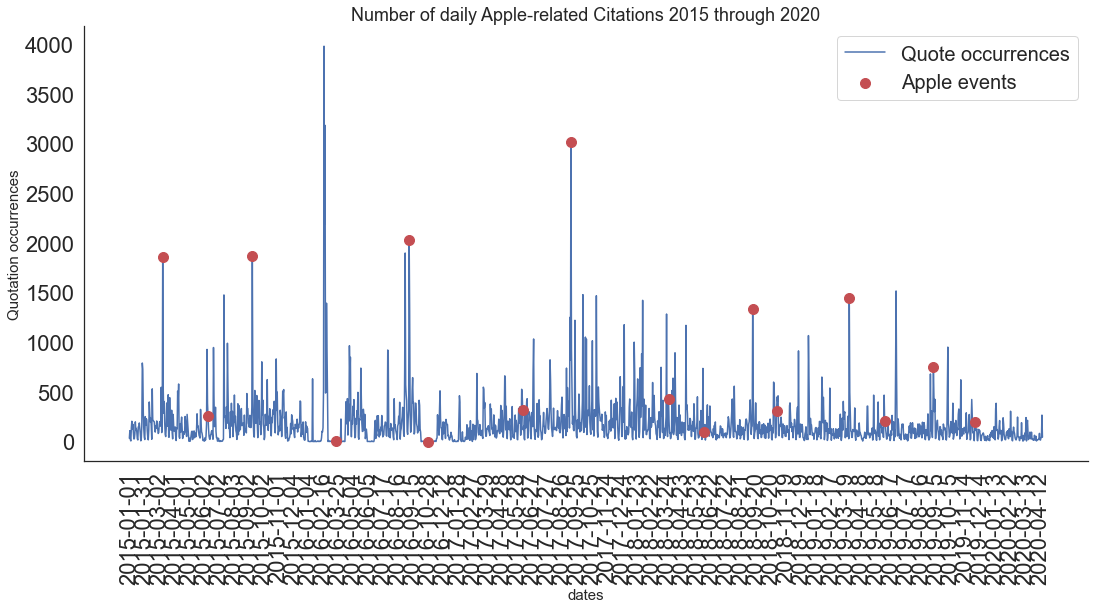

In [60]:
# slice the data frame 
time = df.groupby(['date_clean']).sum().index
quote_num = df.groupby(['date_clean']).sum()['numOccurrences']
fig,ax = plt.subplots(figsize=(18,8))
ax.plot(time,quote_num, label= "Quote occurrences")
ax.set_xlabel("dates",size=15)
ax.scatter(time[time.isin(apple_event_dates_str)],quote_num[time.isin(apple_event_dates_str)], c="r", s=100, zorder=3, label='Apple events')
plt.xticks(time[::30],rotation=90)
ax.set_ylabel("Quotation occurrences",size=15)
ax.set_title("Number of daily Apple-related Citations 2015 through 2020",size=18)
ax.legend(prop={'size': 20})
plt.show()

**Quantifying the media attention**

To quantify the media attention for a given Apple event, the following metrics are formulated:
- **Attention**: The number of weekly quote occurrences.
- **Baseline attention**: Average attention throughout the time period.
- **Event attention**: Avg. of quote occurrences through event week, prior and post week.
- **Event attention increase %**: (Event attention - Baseline attention) / Baseline attention.


To be able to compute these metrics, as well as make further analysis possible, we create the following dataframe:

*Columns:* \
Event-date, attention_week3_pre, attention_week2_pre, attention_week1_pre, attention_week0, attention_week1_post, attention_week2_post, attention_week3_post


In [61]:
df_events = pd.DataFrame()
events = []
for date in apple_event_dates:
    if (date.year == 2019 and date.month < 12) or date.year < 2020:
        events.append(date)
df_events['event_date'] = events

# group data frame by week and year to get weekly attention numbers
df['week'] = df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
df['year'] = df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
df['yearweek'] = df['week'] + df['year']
df_attention = df.groupby(['year','week']).sum().reset_index()


# group sentiment data frame
sentiment_df['week'] = sentiment_df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[1]), axis=1)
sentiment_df['year'] = sentiment_df.apply(lambda x: str(x['date_clean_datetime'].isocalendar()[0]), axis=1)
sentiment_week = sentiment_df.groupby(['year','week']).mean().reset_index()

def attention_query(date, num_weeks):
    "adds weeks to date and returns the attention the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    count = df_attention.loc[(df_attention.week == week) & (df_attention.year == year)].numOccurrences.item()
    return count

def sentiment_query(date, num_weeks):
    "adds weeks to date and returns the sentiment the corresponding week and year"
    new_date = date + dt.timedelta(weeks=num_weeks)
    year = str(new_date.isocalendar()[0])
    week = str(new_date.isocalendar()[1])
    sentiment = sentiment_week.loc[(sentiment_week.week == week) & (sentiment_week.year == year)].compound.item()
    return sentiment

# Create columns for all events
for i in [-3,-2,-1,0,1,2,3]:
    df_events[f"""attention_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: attention_query(x['event_date'], i),axis=1)
    df_events[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = df_events.apply(lambda x: sentiment_query(x['event_date'], i),axis=1)

attention_columns =  [ 'attention_week-3_pre', 'attention_week-2_pre',  'attention_week-1_pre', 'attention_week0','attention_week1_post', 'attention_week2_post','attention_week3_post']
sentiment_columns = ['sentiment_week-3_pre','sentiment_week-2_pre','sentiment_week-1_pre','sentiment_week0','sentiment_week1_post','sentiment_week2_post', 'sentiment_week3_post']



Let's visualize the typical distribution of media attention

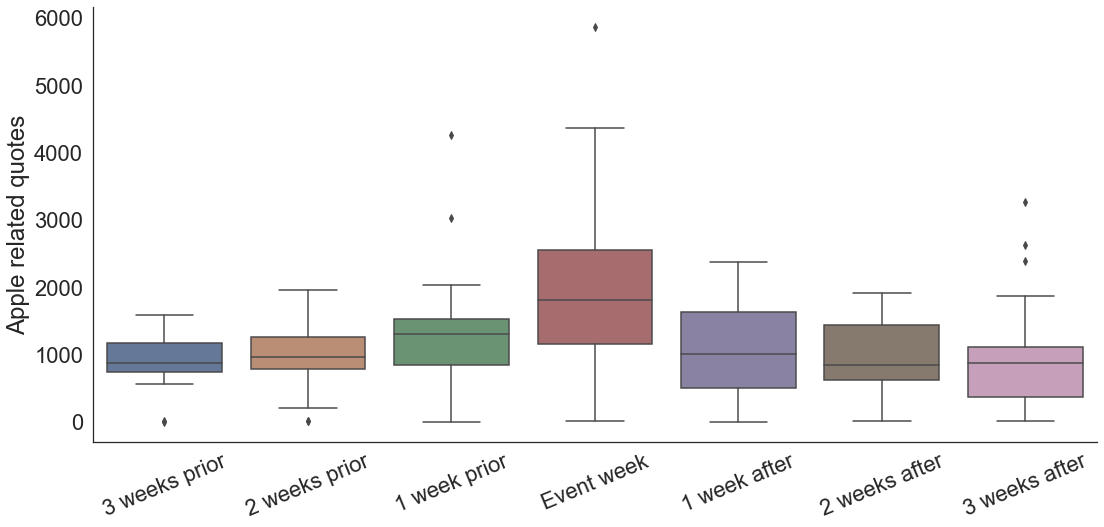

In [62]:
fig,ax = plt.subplots(figsize=(18,8))
sns.set(font_scale=2)
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False},
              font_scale=2)
ax = sns.boxplot(data=df_events[attention_columns],
                     saturation=0.5)
#ax.set_title("Media attention before, during and after an Apple event")
ax.set_ylabel("Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels, rotation=22.5);
#sns.despine(fig)


Looking at the medians, we see that the media attention rises until the week of the event where it peaks and then gradually declines in the following weeks. This shows that Apple is able to build anticipation in the media when launching new products.

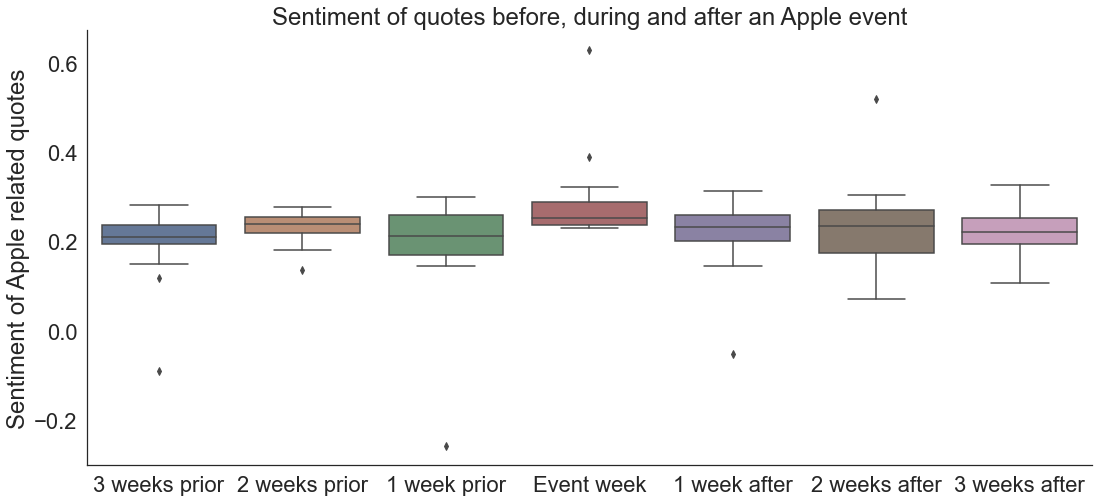

In [63]:
fig,ax = plt.subplots(figsize=(18,8))
ax = sns.boxplot(data=df_events[sentiment_columns],
                     saturation=0.5)
ax.set_title("Sentiment of quotes before, during and after an Apple event")
ax.set_ylabel("Sentiment of Apple related quotes")
positions = (0,1, 2, 3, 4, 5, 6)
labels = ("3 weeks prior", "2 weeks prior", "1 week prior","Event week", "1 week after", "2 weeks after", "3 weeks after")
plt.xticks(positions, labels);

Above we see a boxplot of the average sentiment of the quotes in the weeks prior to and after an apple event. The sentiment value ranges from -1 to 1, with 1 being very positive and -1 being very negative. Across all weeks, we see that the sentiment of the quotes typically lies around 0.2, indicidating a slight positive sentiment in the quotes but mostly neutral. Although the medians do not differ much, the median of the event week is still the highest value. From this we can conclude that Apple generally has a stable reputation in the media, with slightly positive quotes made about them on average.

In [64]:
# Compute baseline
baseline = df_attention.numOccurrences.mean()
df_events['baseline'] = baseline

# Compute average of attention in the weeks prior and after an event 
columns = ['attention_week-3_pre', 'attention_week-2_pre','attention_week-1_pre', 'attention_week0', 'attention_week1_post', 'attention_week2_post', 'attention_week3_post']
df_events['event_attention'] = df_events[columns].mean(axis=1)
df_events['attention_increase'] =  100 * (df_events.event_attention - df_events.baseline) / df_events.baseline
df_events['color'] = df_events.apply(lambda x: 'indianred' if x['attention_increase'] < 0  else 'seagreen',axis=1)
df_events

,event_date,attention_week-3_pre,sentiment_week-3_pre,attention_week-2_pre,sentiment_week-2_pre,attention_week-1_pre,sentiment_week-1_pre,attention_week0,sentiment_week0,attention_week1_post,sentiment_week1_post,attention_week2_post,sentiment_week2_post,attention_week3_post,sentiment_week3_post,baseline,event_attention,attention_increase,color
0,2015-03-09,1592,0.205073,950,0.180802,1484,0.213330,3415,0.239223,1491,0.180105,1327,0.195294,872,0.241140,1174.646209,1590.142857,35.372067,seagreen
1,2015-06-10,844,0.238879,787,0.242997,293,0.293364,1817,0.266030,1388,0.284735,1307,0.286210,56,0.215227,1174.646209,927.428571,-21.046136,indianred
2,2015-09-09,1377,0.268644,1550,0.220960,1469,0.193604,3200,0.234183,1979,0.223281,1715,0.248565,1879,0.261230,1174.646209,1881.285714,60.157646,seagreen
3,2016-03-21,13,0.150282,14,0.191808,13,0.258775,21,0.388664,11,-0.052400,233,0.071750,12,0.121709,1174.646209,45.285714,-96.144736,indianred
4,2016-06-15,1181,0.195502,207,0.254150,7,-0.256371,9,0.628667,5,0.195940,514,0.118771,977,0.184652,1174.646209,414.285714,-64.731022,indianred
5,2016-09-07,1300,0.233880,1270,0.267545,4266,0.170580,4366,0.288352,2370,0.258917,1491,0.229842,1114,0.255799,1174.646209,2311.000000,96.740089,seagreen
6,2016-10-27,3,-0.089533,9,0.263886,16,0.261529,21,0.254050,2,0.278700,9,0.520300,18,0.106510,1174.646209,11.142857,-99.051386,indianred
7,2017-06-07,875,0.229775,973,0.277313,1478,0.160007,1654,0.238226,1634,0.226762,1435,0.238627,2385,0.221446,1174.646209,1490.571429,26.895351,seagreen
8,2017-09-12,1419,0.237112,1823,0.266726,3024,0.222283,5872,0.263193,2161,0.233814,1680,0.213406,2633,0.197567,1174.646209,2658.857143,126.353869,seagreen
9,2018-03-27,1090,0.200885,1961,0.219306,2037,0.229726,1244,0.235145,1738,0.254578,1921,0.234388,1106,0.200995,1174.646209,1585.285714,34.958569,seagreen


###

Now looking at how different apple events have deviated from the attention average

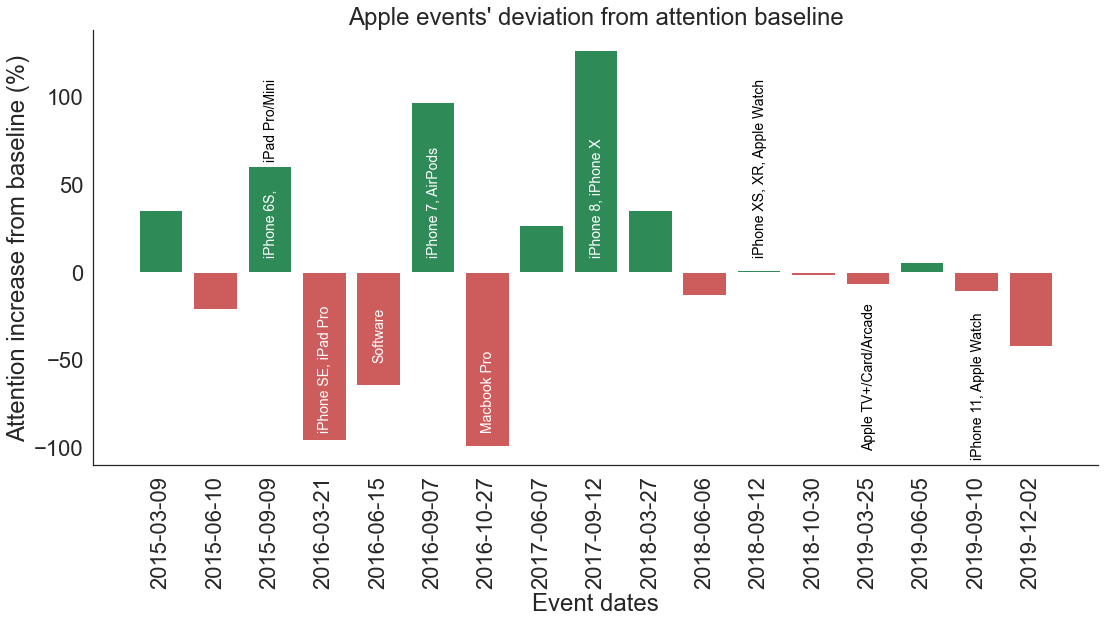

In [65]:
fig,ax = plt.subplots(figsize=(18,8))
plt.bar(x=apple_event_dates_str[:17],height=df_events.attention_increase,color=df_events.color)
plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10.9, 10, "iPhone XS, XR, Apple Watch", fontsize=14,rotation=90,color="black")
plt.text(7.9, 10, "iPhone 8, iPhone X", fontsize=14,rotation=90,color="white")
plt.text(4.9, 10, "iPhone 7, AirPods", fontsize=14,rotation=90,color="white")
plt.text(1.9, 10, "iPhone 6S,", fontsize=14,rotation=90,color="white")
plt.text(1.9, 65, "iPad Pro/Mini", fontsize=14,rotation=90,color="black")
plt.text(5.9, -90, "Macbook Pro", fontsize=14,rotation=90,color="white");
plt.text(2.9, -90, "iPhone SE, iPad Pro", fontsize=14,rotation=90,color="white");
plt.text(3.9, -50, "Software", fontsize=14,rotation=90,color="white");
plt.text(12.9, -100, "Apple TV+/Card/Arcade", fontsize=14,rotation=90,color="black");
plt.text(14.9, -105, "iPhone 11, Apple Watch", fontsize=14,rotation=90,color="black");

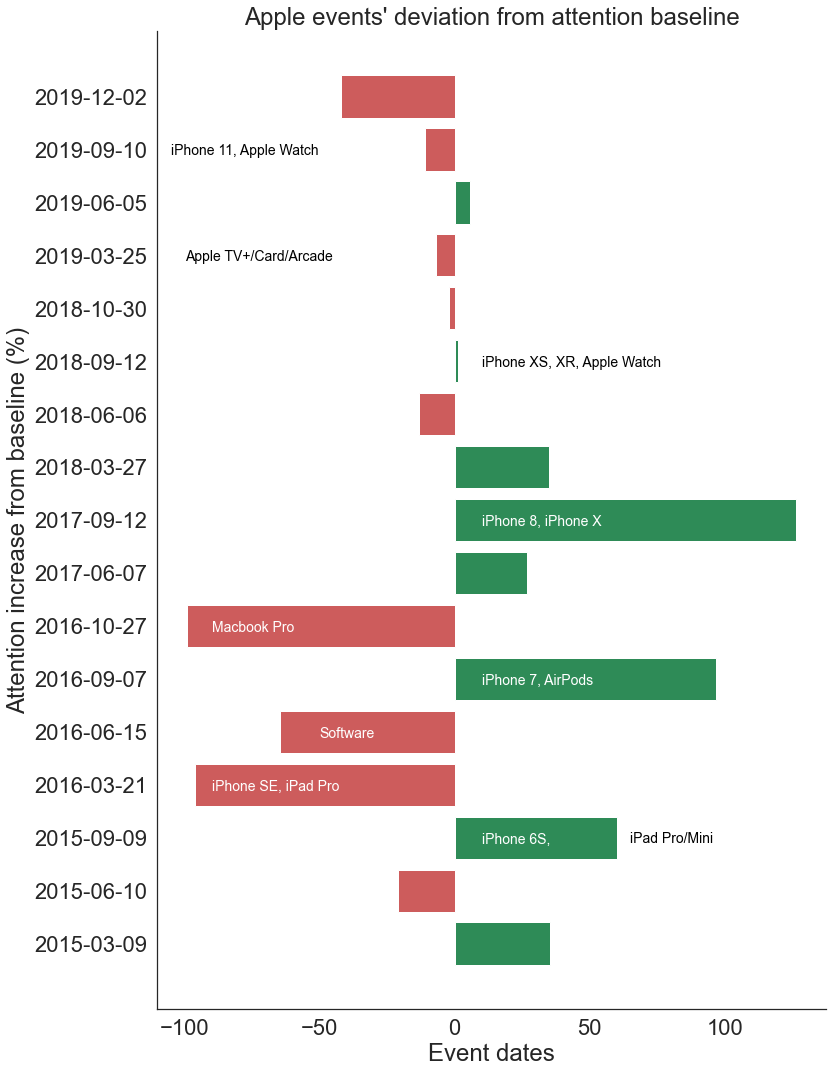

In [66]:
fig,ax = plt.subplots(figsize=(12,18))
plt.barh(y=apple_event_dates_str[:17],width=df_events.attention_increase,color=df_events.color)
#plt.xticks(rotation=90)
plt.xlabel("Event dates")
plt.ylabel("Attention increase from baseline (%)")
plt.title("Apple events' deviation from attention baseline")
plt.text(10, 10.9, "iPhone XS, XR, Apple Watch", fontsize=14, color="black")
plt.text(10, 7.9, "iPhone 8, iPhone X", fontsize=14,color="white")
plt.text(10, 4.9, "iPhone 7, AirPods", fontsize=14,color="white")
plt.text(10, 1.9, "iPhone 6S,", fontsize=14,color="white")
plt.text(65, 1.9, "iPad Pro/Mini", fontsize=14,color="black")
plt.text(-90, 5.9, "Macbook Pro", fontsize=14,color="white");
plt.text(-90, 2.9, "iPhone SE, iPad Pro", fontsize=14,color="white");
plt.text(-50, 3.9, "Software", fontsize=14,color="white");
plt.text(-100, 12.9, "Apple TV+/Card/Arcade", fontsize=14,color="black");
plt.text(-105, 14.9, "iPhone 11, Apple Watch", fontsize=14,color="black");

## Does the sentiment of quarter earning announcements differ from product launches?

In [67]:
quarterly_earnings=pd.read_excel('./data/Earnings_Apple.xlsx')

#Remove the unnecessary rows in the quarterly_earnings
quarterly_earnings=quarterly_earnings.drop(index=[0,1,2,3,4,5,6,7])

#Change the format of the Earnings Date column
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: x.replace(", 12 AMEST", "").replace(",", ""))
quarterly_earnings["Earnings Date"]=quarterly_earnings["Earnings Date"].map(lambda x: dt.datetime.strptime(x, "%b %d %Y"))

#Clean surprise factor\n",
quarterly_earnings["Surprise(%)"] = quarterly_earnings["Surprise(%)"].map(lambda x: -1*x[1:] if x[0] == '-' else x[1:])

# Remove dates before 2020\n",
to_drop = []
for i, date in enumerate(quarterly_earnings["Earnings Date"]):
    if date.year > 2019:
        to_drop.append(i+8)
quarterly_earnings = quarterly_earnings.drop(index=to_drop,axis=0)

# Add sentiment columns\n"
for i in [-3,-2,-1,0,1,2,3]:
    quarterly_earnings[f"""sentiment_week{i}{'_pre' if i < 0 else '_post' if i > 0 else ''}"""] = quarterly_earnings.apply(lambda x: sentiment_query(x['Earnings Date'], i),axis=1)

Text(0.5, 1.0, 'Comparison of mean sentiment for product launches and earning announcements')

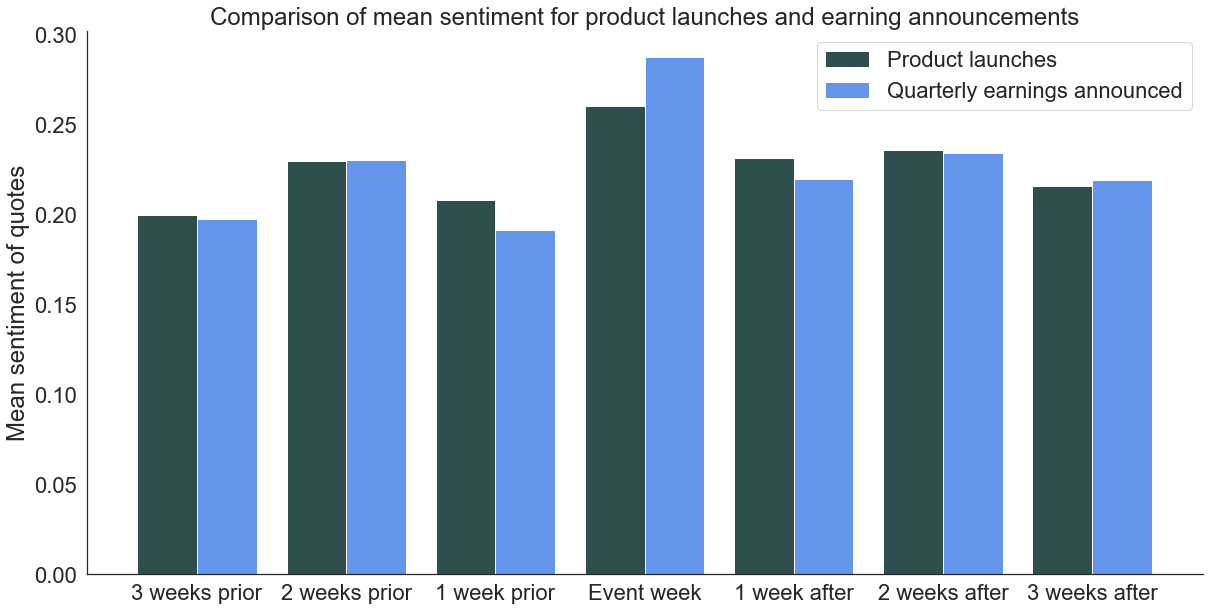

In [68]:
a = quarterly_earnings[sentiment_columns].mean().tolist()
b = df_events[sentiment_columns].mean().tolist()

# plot data in grouped manner of bar type\n",
plt.subplots(figsize=(20,10))
x = np.arange(7)
width = 0.4
plt.bar(x-0.2, a, width,color='darkslategrey')
plt.bar(x+0.2, b, width,color='cornflowerblue')
plt.xticks(x,labels)
plt.legend(['Product launches', 'Quarterly earnings announced'])
plt.ylabel("Mean sentiment of quotes")
plt.title("Comparison of mean sentiment for product launches and earning announcements")


Looking at the plot above, it can be seen that the sentiment of quotes before and after product launches on average are very similar the sentiment of quotes before and after announcements of quarterly earnings. The quotes are, however, generally more positive in the weeks where quarterly earnings are announced than in the weeks where new products are launched. This can be explained by the fact that quarterly reports typically are described with more adjectives, whereas product launches may be more factual and thus neutral.

Text(0, 0.5, 'Mean sentiment of quotes')

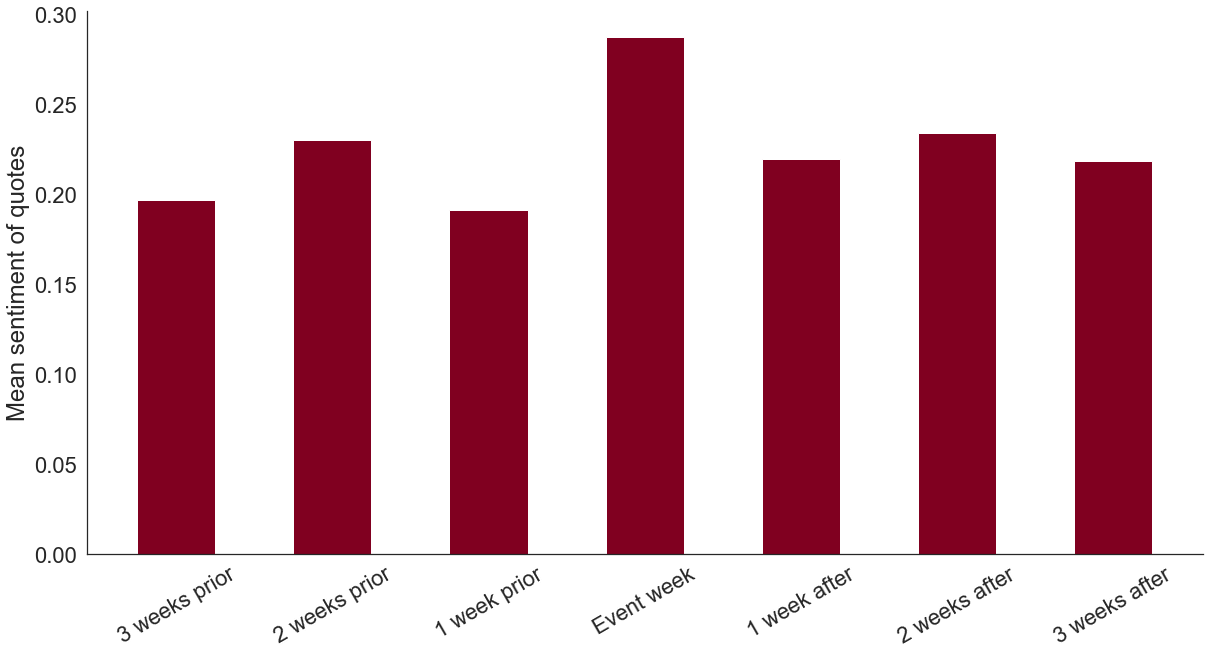

In [69]:

b = df_events[sentiment_columns].mean().tolist()

# set theme of plot
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font='Arial', font_scale=2)
# plot data in grouped manner of bar type\n",
plt.subplots(figsize=(20,10))
x = np.arange(7)
width = 0.5
#plt.bar(x-0.2, a, width,color='darkslategrey')
plt.bar(x, b, width,color='#800020')
plt.xticks(x,labels, rotation=30)
#plt.legend(['Product launches', 'Quarterly earnings announced'])
plt.ylabel("Mean sentiment of quotes")
#plt.title("Comparison of mean sentiment for product launches and earning announcements")

From the plot it is clear that the not only the attention, but also the sentiment towards Apple increases during an event week. In addition the plot indicates that the sentiment in the weeks after an event is more positive than the weeks prior. To investigate this we will perform a Mann Whitney U-test, a robust, non-parametric test which measures whether there exist a significant difference between to distributions. 

Source: [Towards Data Science](https://towardsdatascience.com/intro-to-data-science-part-3-data-analysis-71a566c3a8c3)

In [70]:
df_events.columns

Index(['event_date', 'attention_week-3_pre', 'sentiment_week-3_pre',
       'attention_week-2_pre', 'sentiment_week-2_pre', 'attention_week-1_pre',
       'sentiment_week-1_pre', 'attention_week0', 'sentiment_week0',
       'attention_week1_post', 'sentiment_week1_post', 'attention_week2_post',
       'sentiment_week2_post', 'attention_week3_post', 'sentiment_week3_post',
       'baseline', 'event_attention', 'attention_increase', 'color'],
      dtype='object')

In [71]:
# Make numpy representations of weeks prior to event, and posterior to event
pre_columns = ['sentiment_week-3_pre', 'sentiment_week-2_pre', 'sentiment_week-1_pre']
post_columns = ['sentiment_week3_post', 'sentiment_week2_post', 'sentiment_week1_post']

prior_weeks = np.mean(df_events[pre_columns], axis=1)
posterior_weeks = np.mean(df_events[post_columns], axis=1)
event_week = df_events["sentiment_week0"]

# Combine prior and posterior to represent all weeks except event week
prior_posterior = np.array([prior_weeks, posterior_weeks]).T

# Conduct test between weeks prior and posterior
test_result = mannwhitneyu(prior_weeks, posterior_weeks)

print(f'Sentiment for the three weeks prior to a launch:')
print(f'Mean: {prior_weeks.mean()}, Standard Deviation: {prior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Sentiment for the three weeks posterior to a launch:')
print(f'Mean: {posterior_weeks.mean()}, Standard Deviation: {posterior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Mann Whitney U-Test: {test_result}')

# Conduct test between event week and all other
event_rest = mannwhitneyu(prior_posterior.mean(axis=1), event_week)
print('----------------------------------------------------------------------')
print(f'Sentiment for event week:')
print(f'Mean: {posterior_weeks.mean()}, Standard Deviation: {posterior_weeks.std()}')
print('----------------------------------------------------------------------')
print(f'Mann Whitney U-Test between event week and all other: {event_rest}')

Sentiment for the three weeks prior to a launch:
Mean: 0.20627618746342166, Standard Deviation: 0.04871004184738456
----------------------------------------------------------------------
Sentiment for the three weeks posterior to a launch:
Mean: 0.22426916117447848, Standard Deviation: 0.05900636970657237
----------------------------------------------------------------------
Mann Whitney U-Test: MannwhitneyuResult(statistic=113.0, pvalue=0.28563352706656997)
----------------------------------------------------------------------
Sentiment for event week:
Mean: 0.22426916117447848, Standard Deviation: 0.05900636970657237
----------------------------------------------------------------------
Mann Whitney U-Test between event week and all other: MannwhitneyuResult(statistic=38.0, pvalue=0.00026120660215923273)


Mann Whitney U-test that the two distributions are equal. The p-value represents the percentages of times we would see a similar (or more extreme) result as our obeservations given this assumption. Since the p-value is ~0.3, by drawing two random samples from the same distribution would yield at least as big difference as observed. This difference is not significant.

### Does the sentiment/attention before and after a product launch correlate with changes in the stock price?

In [72]:
# Calculate sentiment change for each of the product launches
df_events['sentiment_change'] = df_events["sentiment_week1_post"] - df_events['sentiment_week-1_pre']
df_events['attention_change'] = df_events["attention_week1_post"] - df_events['attention_week-1_pre']


# Calculate the change in stock price before and after each stock price (average of the week before to the week after)
stock_data_events=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
stock_data_events.Date = pd.to_datetime(stock_data_events.Date) - pd.to_timedelta(7, unit='d')
stock_data_events = stock_data_events.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')
stock_data_events['week'] = stock_data_events.apply(lambda x: x['Date'].week,axis=1)
stock_data_events['year'] = stock_data_events.apply(lambda x: x['Date'].year,axis=1)

def stock_query(date):
    "Given date returns the difference between the stockprice the week before and after said date"
    year = date.isocalendar()[0]
    week = date.isocalendar()[1]
    stock_start = stock_data_events.loc[(stock_data_events.week == week - 1) & (stock_data_events.year == year)].Open.item()
    stock_end = stock_data_events.loc[(stock_data_events.week == week + 1) & (stock_data_events.year == year)].Close.item()

    diff = stock_start - stock_end
    return diff


df_events["stock_change"] = df_events.apply(lambda x: stock_query(x['event_date']),axis=1)

Let's see if there is any connection between the change in stock price and sentiment/attention

Text(0, 0.5, 'Difference in attention score after product launch ')

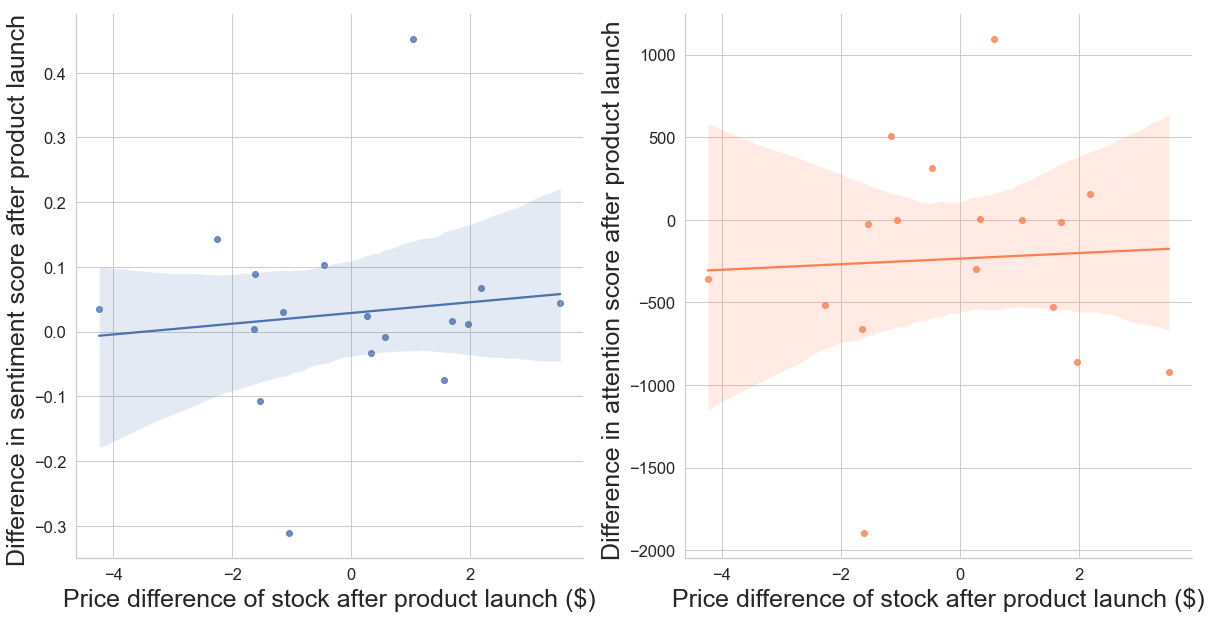

In [88]:
sns.set_theme(font_scale=1.5, style='whitegrid', font='Arial', rc={"axes.spines.right": False, "axes.spines.top": False})
fig, axes =plt.subplots(1,2,figsize=(20,10))
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font_scale=2)
sns.regplot(ax=axes[0], x=df_events["stock_change"], y=df_events["sentiment_change"])
axes[0].set_xlabel('Price difference of stock after product launch ($)', size=25)
axes[0].set_ylabel('Difference in sentiment score after product launch ', size=25)
sns.regplot(ax=axes[1],x=df_events["stock_change"], y=df_events["attention_change"],color='coral')
axes[1].set_xlabel('Price difference of stock after product launch ($)', size=25)
axes[1].set_ylabel('Difference in attention score after product launch ', size=25)

#fig.suptitle('Does changes in sentiment/attention after a product launch correlate with changes in stock prices?')

In [74]:
import statsmodels.api as sm
mod = sm.OLS(df_events["stock_change"],df_events["sentiment_change"])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           stock_change   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):             -0.051
Method:                 Least Squares   F-statistic:                             0.1703
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                       0.685
Time:                        12:01:13   Log-Likelihood:                         -34.933
No. Observations:                  17   AIC:                                      71.87
Df Residuals:                      16   BIC:                                      72.70
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/OlavFoerland/opt/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [75]:
mod = sm.OLS(df_events["stock_change"],df_events["attention_change"])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:           stock_change   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.059
Method:                 Least Squares   F-statistic:                            0.04802
Date:                Fri, 17 Dec 2021   Prob (F-statistic):                       0.829
Time:                        12:01:13   Log-Likelihood:                         -34.998
No. Observations:                  17   AIC:                                      72.00
Df Residuals:                      16   BIC:                                      72.83
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/OlavFoerland/opt/anaconda3/envs/ada/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Both regression lines have very low R^2-values indicating a poor fit. To conclude, the change in stock price from the week before an event to the week after an event can neither be explained by the corresponding change in attention level nor the change in sentiment.

s